In [1]:
import os
import numpy as np
import pandas as pd
from Bio.PDB.Polypeptide import three_to_index
from Bio.PDB.Polypeptide import one_to_three
# res to index
# index_dic
parameter_folder = "/Users/weilu/Research/database/"

if os.path.exists(f"{parameter_folder}/gxxxg_index_dic_v5.csv"):
    info = pd.read_csv(f"{parameter_folder}/gxxxg_index_dic_v5.csv", index_col=0)
    interaction_index_dic = {}
    n = 20
    for i, line in info.iterrows():
        # print(i, line["i"])
        interaction_index_dic[f"{line['Direction']}_{line['i']}"] = line["Group"]


def get_400_based_index(res1_1, res1_2):
    index = three_to_index(res1_1)*20 + three_to_index(res1_2)
    return index
def get_overall_index_v5(index1, index2, direction, interaction_index_dic):
    n = 20
    # plus 1, total parameters. 21*20/2 = 210
    n_shift = 210
    new_index1 = interaction_index_dic[f"{direction}_{index1}"]
    new_index2 = interaction_index_dic[f"{direction}_{index2}"]
    if new_index1 > new_index2:
        new_index1, new_index2 = new_index2, new_index1
    overall_index = ((2*n-(new_index1-1))*(new_index1)/2 + new_index2 - new_index1)
    if direction == "anti":
        overall_index += n_shift
    return int(overall_index)

def get_interaction_index_from_four_residues_v5(res1_1, res1_2, res2_1, res2_2, direction, interaction_index_dic=interaction_index_dic):

    index1 = get_400_based_index(res1_1, res1_2)
    if direction == "parallel":
        index2 = get_400_based_index(res2_1, res2_2)
    elif direction == "anti":
        index2 = get_400_based_index(res2_2, res2_1)
    else:
        print("unknown direction")
        raise
    index = get_overall_index_v5(index1, index2, direction, interaction_index_dic)

    return index


def dis(a, b):
    return ((a[0]-b[0])**2 + (a[1]-b[1])**2 + (a[2]-b[2])**2)**0.5

def get_side_chain_center_of_mass(res):
    atoms = res.get_atoms()
    total = np.array([0., 0., 0.])
    total_mass = 0
    for atom in atoms:
        if atom.get_name() in ["N", "CA", "C", "O"]:
            continue
        if atom.element == "H":
            continue
        total += atom.mass * atom.get_coord()
        total_mass += atom.mass
        # print(atom.get_name(), atom.get_coord())
    if total_mass == 0:
        x_com = res["CA"].get_coord()
    else:
        x_com = total / total_mass
    return x_com

def get_interaction_distance_com(res1, res2):
    # when Some Amino acids is mutated to GLY.
    # I want it still use the COM of side chain. not the position of CA.
    x1 = get_side_chain_center_of_mass(res1)
    x2 = get_side_chain_center_of_mass(res2)
    return dis(x1, x2)

def get_local_index(residue):
    return residue.get_id()[1]


def get_global_index(residue_list, residue):
    return residue_list.index(residue)


def get_chain(residue):
    return residue.get_parent().get_id()

def get_interaction_atom(residue):
    try:
        if residue.resname == "GLY":
            res = residue['CA']
            return res
        else:
            res = residue['CB']
            return res
    except:
        # print(residue)
        # print("----------Use CA instead---------------")
        # probably because mutation.
        try:
            res = residue['CA']
            return res
            # raise
        except:
            # print("no CA found, work around is to just use any atom")
            # return list(residue.get_atoms())[0]
            print("need debug", residue)
            raise

def get_neighbors_within_radius(neighbor_list, residue, radius):
    return neighbor_list.search(get_interaction_atom(residue).get_coord(), radius, level='R')

def get_res_by_globalindex(res_list, index, chain):
    # the res has to be on the same chain as "chain"
    if index < 0:
        return -1
    try:
        res = res_list[index]
    except:
        return -1
    if res.get_parent().get_id() == chain:
        return res
    else:
        return -1
def interaction_well(r, r_min, r_max, kappa):
    return 0.5 * (np.tanh(kappa * (r - r_min)) * np.tanh(kappa * (r_max - r))) + 0.5


from Bio.PDB import PDBParser
from Bio.PDB import NeighborSearch
from Bio.PDB import Selection
from Bio.PDB import PPBuilder
def parse_pdb(pdb_id):
    parser = PDBParser()
    return parser.get_structure(pdb_id, "%s.pdb" % pdb_id)
def is_hetero(residue):
    if residue.id[0] != ' ':
        return True
    else:
        return False
def get_res_list(structure):
    res_list = Selection.unfold_entities(structure, 'R')
    # Get all residues from a structure
    res_list = [residue for residue in res_list if not is_hetero(residue)]
    return res_list
def get_atom_list(structure):
    atom_list = Selection.unfold_entities(structure, 'A')  # A for atoms
    return atom_list
def get_neighbor_list(structure):

    res_list = get_res_list(structure)
    atom_list = [a for a in get_atom_list(
        structure) if not is_hetero(a.get_parent())]
    # print(atom_list)
    neighbor_list = NeighborSearch(atom_list)
    return neighbor_list
def get_sequence_from_structure(structure):
    sequence = ""
    ppb = PPBuilder(radius=10.0)
    for pp in ppb.build_peptides(structure, aa_only=False):
        sequence += '%s\n' % pp.get_sequence()
    return sequence.replace('\n', '')


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = np.array([10,6.180])    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'

In [3]:
def get_phi_info_gxxxg_v5_well(res_list, neighbor_list, parameter_list):
    info = []
    min_seq_sep = 10
    r_min = 2.0
    r_max = 6.5
    r_cutoff = 8.5
    kappa = 5
    n_parameters = 420
    info_list = []
    get_distance_between_two_residues = get_interaction_distance_com
    phi_gxxxg_well = np.zeros(n_parameters)
    for res1globalindex, res1 in enumerate(res_list):
        res1index = get_local_index(res1)
        res1chain = get_chain(res1)
        for res2 in get_neighbors_within_radius(neighbor_list, res1, r_cutoff):
            res2index = get_local_index(res2)
            res2chain = get_chain(res2)
            res2globalindex = get_global_index(res_list, res2)

            for shift_to_res2_2, direction in zip([-4, 4], ["anti", "parallel"]):
                res1_2_globalindex = res1globalindex + 4
                res1_2 = get_res_by_globalindex(res_list, res1_2_globalindex, res1chain)
                # for shift_to_res2_2 in [-4, 4]:

                # consider parallel, and anti-parallel.
                res2_2_globalindex = res2globalindex + shift_to_res2_2
                res2_2 = get_res_by_globalindex(res_list, res2_2_globalindex, res2chain)
                if res1_2 == -1 or res2_2 == -1:
                    continue
                if direction == "parallel":
                    group2index = res2globalindex
                elif direction == "anti":
                    group2index = res2_2_globalindex
                sep = group2index - res1globalindex
                if (res1chain == res2chain and sep >= min_seq_sep) or (res1chain != res2chain and group2index > res1globalindex):
                    rij = get_distance_between_two_residues(res1, res2)

                    rij_2 = get_distance_between_two_residues(res1_2, res2_2)
                    if rij_2 > r_cutoff or rij > r_cutoff:
                        continue

                    res1_name = res1.resname
                    res1_2_name = res1_2.resname
                    res2_name = res2.resname
                    res2_2_name = res2_2.resname
                    # interaction_index = get_interaction_index_from_four_residues_v5(res1.resname, res1_2.resname, res2.resname, res2_2.resname, direction)
                    interaction_index = get_interaction_index_from_four_residues_v5(res1_name, res1_2_name, res2_name, res2_2_name, direction)
                    phi_ = interaction_well(rij, r_min, r_max, kappa) * interaction_well(rij_2, r_min, r_max, kappa)
                    # phi_gxxxg_well[interaction_index] += phi_
                    phi_gxxxg_well[interaction_index] += phi_
                    if phi_ > 1e-5:
                        info.append([round(phi_,4), res1globalindex, res1_2_globalindex, res2globalindex, res2_2_globalindex, direction, res1_name, res1_2_name, res2_name, res2_2_name, interaction_index])
    info = pd.DataFrame(info, columns=["phi", "res1", "res1_2", "res2", "res2_2", "direction", "res1_name", "res1_2_name", "res2_name", "res2_2_name", "interaction_index"])
    return info

In [4]:
def get_overall_index_v6(index1, index2, direction, interaction_index_dic):
    n = 400
    # plus 1, total parameters. 401*400/2 = 80200
    n_shift = 80200
    new_index1 = index1
    new_index2 = index2
    if new_index1 > new_index2:
        new_index1, new_index2 = new_index2, new_index1
    overall_index = ((2*n-(new_index1-1))*(new_index1)/2 + new_index2 - new_index1)
    if direction == "anti":
        overall_index += n_shift
    return int(overall_index)

def get_interaction_index_from_four_residues_v6(res1_1, res1_2, res2_1, res2_2, direction):

    index1 = get_400_based_index(res1_1, res1_2)
    if direction == "parallel":
        index2 = get_400_based_index(res2_1, res2_2)
    elif direction == "anti":
        index2 = get_400_based_index(res2_2, res2_1)
    else:
        print("unknown direction")
        raise
    index = get_overall_index_v6(index1, index2, direction, interaction_index_dic)

    return index

def get_phi_info_gxxxg_v6_well(res_list, neighbor_list, parameter_list, n_parameters=420, get_interaction_index_from_four_residues=None):
    info = []
    min_seq_sep = 10
    r_min = 2.0
    r_max = 6.5
    r_cutoff = 8.5
    kappa = 5
    info_list = []
    get_distance_between_two_residues = get_interaction_distance_com
    phi_gxxxg_well = np.zeros(n_parameters)
    for res1globalindex, res1 in enumerate(res_list):
        res1index = get_local_index(res1)
        res1chain = get_chain(res1)
        for res2 in get_neighbors_within_radius(neighbor_list, res1, r_cutoff):
            res2index = get_local_index(res2)
            res2chain = get_chain(res2)
            res2globalindex = get_global_index(res_list, res2)

            for shift_to_res2_2, direction in zip([-4, 4], ["anti", "parallel"]):
                res1_2_globalindex = res1globalindex + 4
                res1_2 = get_res_by_globalindex(res_list, res1_2_globalindex, res1chain)
                # for shift_to_res2_2 in [-4, 4]:

                # consider parallel, and anti-parallel.
                res2_2_globalindex = res2globalindex + shift_to_res2_2
                res2_2 = get_res_by_globalindex(res_list, res2_2_globalindex, res2chain)
                if res1_2 == -1 or res2_2 == -1:
                    continue
                if direction == "parallel":
                    group2index = res2globalindex
                elif direction == "anti":
                    group2index = res2_2_globalindex
                sep = group2index - res1globalindex
                if (res1chain == res2chain and sep >= min_seq_sep) or (res1chain != res2chain and group2index > res1globalindex):
                    rij = get_distance_between_two_residues(res1, res2)

                    rij_2 = get_distance_between_two_residues(res1_2, res2_2)
                    if rij_2 > r_cutoff or rij > r_cutoff:
                        continue

                    res1_name = res1.resname
                    res1_2_name = res1_2.resname
                    res2_name = res2.resname
                    res2_2_name = res2_2.resname
                    # interaction_index = get_interaction_index_from_four_residues_v5(res1.resname, res1_2.resname, res2.resname, res2_2.resname, direction)
                    interaction_index = get_interaction_index_from_four_residues(res1_name, res1_2_name, res2_name, res2_2_name, direction)
                    phi_ = interaction_well(rij, r_min, r_max, kappa) * interaction_well(rij_2, r_min, r_max, kappa)
                    # phi_gxxxg_well[interaction_index] += phi_
                    phi_gxxxg_well[interaction_index] += phi_
                    if phi_ > 1e-5:
                        info.append([round(phi_,4), res1globalindex, res1_2_globalindex, res2globalindex, res2_2_globalindex, direction, res1_name, res1_2_name, res2_name, res2_2_name, interaction_index])
    info = pd.DataFrame(info, columns=["phi", "res1", "res1_2", "res2", "res2_2", "direction", "res1_name", "res1_2_name", "res2_name", "res2_2_name", "interaction_index"])
    return info


def get_phis_from_info_and_sequence(info, sequence, get_interaction_index_from_four_residues=get_interaction_index_from_four_residues_v5, verbose=False):
    n_parameters = 420
    phi_gxxxg_well = np.zeros(n_parameters)
    skip_count = 0
    for i, line in info.iterrows():
        direction = line["direction"]

        res1_index = line["res1"]
        res1_2_index = line["res1_2"]
        res2_index = line["res2"]
        res2_2_index = line["res2_2"]
        try:
            res1_name = one_to_three(sequence[res1_index])
            res1_2_name = one_to_three(sequence[res1_2_index])
            res2_name = one_to_three(sequence[res2_index])
            res2_2_name = one_to_three(sequence[res2_2_index])
        except:
            skip_count += 1
            continue
        interaction_index = get_interaction_index_from_four_residues(res1_name, res1_2_name, res2_name, res2_2_name, direction)
        phi = line["phi"]
        phi_gxxxg_well[interaction_index] += phi
    phis_to_return = []
    for i in range(n_parameters):
        phis_to_return.append(phi_gxxxg_well[i])
    if verbose:
        print("total skipped: ", skip_count)
    return phis_to_return

import random
def shuffle_string(string):
    list_string = list(string)
    random.shuffle(list_string)
    return ''.join(list_string)

In [7]:
pdb = '6s8h_F'

In [8]:
msa = np.loadtxt(f"/Users/weilu/Research/server/aug_2020/curated_single_chain_optimization/alignments/{pdb}_filtered_0.05.seqs", dtype=str)

In [9]:
fileLocation = f"/Users/weilu/Research/server/aug_2020/curated_single_chain_optimization/database/dompdb/{pdb}"
structure = parse_pdb(fileLocation)
res_list = get_res_list(structure)
neighbor_list = get_neighbor_list(structure)
sequence = get_sequence_from_structure(structure)
info = get_phi_info_gxxxg_v5_well(res_list, neighbor_list, [])



In [10]:
%%time
# shuffle the string
# each protein, sample 1000 MSA.
# each MSA, shuffle 100 times
n_parameters = 420
n_msa = 1000
n_shuffle = 1
total_decoys = n_msa * n_shuffle

native_phis = np.zeros((n_msa, n_parameters))
decoy_phis = np.zeros((total_decoys, n_parameters))
random.seed(1)
chosen_msa = random.sample(list(msa), n_msa)
chosen_decoys = []
count = 0
for idx, seq in enumerate(chosen_msa):
    native_phis[idx] = get_phis_from_info_and_sequence(info, seq)
    for i in range(n_shuffle):
        decoy_seq = shuffle_string(seq)
        phis = get_phis_from_info_and_sequence(info, decoy_seq)
        decoy_phis[count] = phis
        count += 1

CPU times: user 31.8 s, sys: 293 ms, total: 32.1 s
Wall time: 32.7 s


In [102]:
import h5py

total_phis = 3000

hdf5_store = h5py.File(f"/Users/weilu/Research/database/test/{pdb}.hdf5", "a")
A = hdf5_store.create_dataset("A", (total_phis, ), compression="gzip")
half_B = hdf5_store.create_dataset("half_B", (total_phis, total_phis), compression="gzip")
std_half_B = hdf5_store.create_dataset("std_half_B", (total_phis, total_phis), compression="gzip")
other_half_B = hdf5_store.create_dataset("other_half_B", (total_phis, total_phis), compression="gzip")
B = hdf5_store.create_dataset("B", (total_phis, total_phis), compression="gzip")

In [103]:
decoy_phis = np.random.random((1000, total_phis))
native_phis = np.random.random((3, total_phis))

In [131]:
all_phis.shape

(1000, 3000)

In [99]:
np.average(phis_i * phis_j, axis=0).shape

(2000,)

In [105]:
import tables

In [108]:
tables.__version__

'3.6.1'

In [ ]:
tables.open_file

In [124]:
a = tables.Float64Atom()

In [125]:
a.dtype

dtype('float64')

In [133]:
h5file.close()

In [ ]:
B = np.loadtxt("/Users/weilu/Research/server/aug_2020/curated_single_chain_optimization/optimization_decoyN2000/gammas/complete_protein_list_phi_gxxxg_v5_well420_B")

In [ ]:
B[B>1]=1
plt.imshow(B)
plt.colorbar()

In [138]:
B = np.loadtxt("/Users/weilu/Research/server/jul_week1_2020/decoyN2000_gxxxg_shuffle_optimization/optimization_decoyN2000/gammas/filtered_protein_list_phi_gxxxg_v2_well126_B")

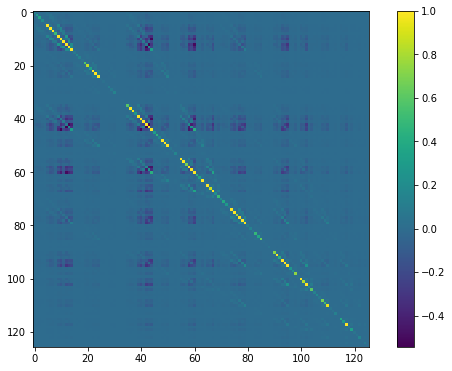

In [144]:
B[B>1]=1
plt.imshow(B)
plt.colorbar()

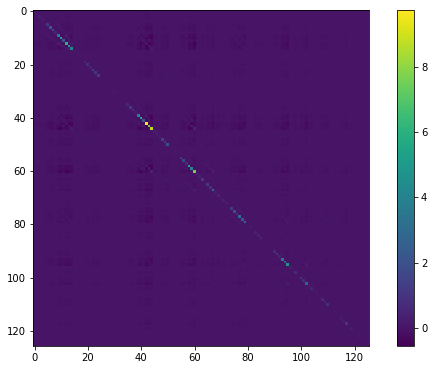

In [139]:
plt.imshow(B)
plt.colorbar()

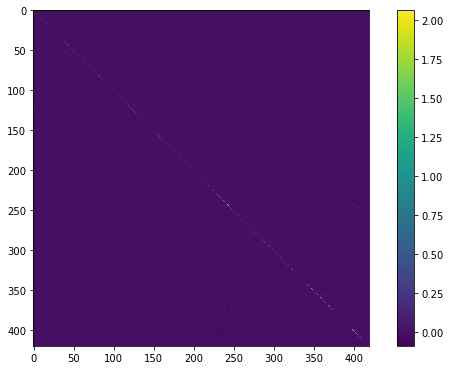

In [136]:
plt.imshow(B)
plt.colorbar()

In [129]:

ndim = 3000
h5file = tables.open_file('/Users/weilu/Research/database/test/test.h5', mode='w', title="Test Array")

root = h5file.root
A = h5file.create_array(root,'A', atom=tables.Float64Atom(),shape=(ndim,))
half_B = h5file.create_array(root,'half_B', atom=tables.Float64Atom(),shape=(ndim, ndim))
std_half_B = h5file.create_array(root,'std_half_B', atom=tables.Float64Atom(),shape=(ndim, ndim))
other_half_B = h5file.create_array(root,'other_half_B', atom=tables.Float64Atom(),shape=(ndim, ndim))
B = h5file.create_array(root,'B', atom=tables.Float64Atom(),shape=(ndim, ndim))
# x[:100,:100] = np.random.random(size=(100,100)) # Now put in some data





In [130]:
%%time
# n 3000
all_phis = decoy_phis
average_phi_decoy = np.average(all_phis, axis=0)
phi_native = np.average(native_phis, axis=0)

A[:] = average_phi_decoy - phi_native
num_decoys, total_phis = all_phis.shape


phis_i = all_phis
for j in range(total_phis):
    phis_j = phis_i[:, j].reshape(num_decoys, 1)
    half_B[j] += np.average(phis_i * phis_j, axis=0).reshape(total_phis)
    std_half_B[j] += np.std(phis_i * phis_j, axis=0).reshape(total_phis)

average_phi = np.average(all_phis, axis=0)
for j in range(total_phis):
    other_half_B[j] = average_phi[j] * average_phi
# other_half_B += average_phi.reshape(total_phis, 1) * average_phi.reshape(1, total_phis)
# B[:] = half_B[:] - other_half_B[:]
h5file.close()

CPU times: user 1min 28s, sys: 16.9 s, total: 1min 45s
Wall time: 1min 47s


In [104]:
%%time
# the hdf5 saving time is the major one.
# n 3000 took 40s without saving the data into disk.
# n 3000
# the average, and std calculation.
all_phis = decoy_phis
average_phi_decoy = np.average(all_phis, axis=0)
phi_native = np.average(native_phis, axis=0)

# A[:] = average_phi_decoy - phi_native
num_decoys, total_phis = all_phis.shape


phis_i = all_phis
for j in range(total_phis):
    phis_j = phis_i[:, j].reshape(num_decoys, 1)
    _ = np.average(phis_i * phis_j, axis=0)
    _ = np.std(phis_i * phis_j, axis=0)

for j in range(total_phis):
    _ = average_phi_decoy[j] * average_phi_decoy
# other_half_B += average_phi.reshape(total_phis, 1) * average_phi.reshape(1, total_phis)
# B[:] = half_B[:] - other_half_B[:]

CPU times: user 1min 20s, sys: 17.2 s, total: 1min 37s
Wall time: 1min 39s


In [92]:
%%time
# n 2000
all_phis = decoy_phis
average_phi_decoy = np.average(all_phis, axis=0)
phi_native = np.average(native_phis, axis=0)

A[:] = average_phi_decoy - phi_native
num_decoys, total_phis = all_phis.shape


phis_i = all_phis
for j in range(total_phis):
    phis_j = phis_i[:, j].reshape(num_decoys, 1)
    half_B[j] += np.average(phis_i * phis_j, axis=0).reshape(total_phis)
    std_half_B[j] += np.std(phis_i * phis_j, axis=0).reshape(total_phis)

average_phi = np.average(all_phis, axis=0)
for j in range(total_phis):
    other_half_B[j] = average_phi[j] * average_phi
# other_half_B += average_phi.reshape(total_phis, 1) * average_phi.reshape(1, total_phis)
# B[:] = half_B[:] - other_half_B[:]

CPU times: user 43.2 s, sys: 7.49 s, total: 50.7 s
Wall time: 52.5 s


In [79]:
%%time
# n 3000
all_phis = decoy_phis
average_phi_decoy = np.average(all_phis, axis=0)
phi_native = np.average(native_phis, axis=0)

A[:] = average_phi_decoy - phi_native
num_decoys, total_phis = all_phis.shape


phis_i = all_phis.reshape(num_decoys, total_phis, 1)
for j in range(total_phis):
    phis_j = phis_i[:, j].reshape(num_decoys, 1, 1)
    half_B[j] += np.average(phis_i * phis_j, axis=0).reshape(total_phis)
    std_half_B[j] += np.std(phis_i * phis_j, axis=0).reshape(total_phis)

average_phi = np.average(all_phis, axis=0)
for j in range(total_phis):
    other_half_B[j] = average_phi[j] * average_phi
# other_half_B += average_phi.reshape(total_phis, 1) * average_phi.reshape(1, total_phis)
# B[:] = half_B[:] - other_half_B[:]

CPU times: user 9min 20s, sys: 7.64 s, total: 9min 28s
Wall time: 9min 33s


In [76]:
%%time
# n 3000
all_phis = decoy_phis
average_phi_decoy = np.average(all_phis, axis=0)
phi_native = np.average(native_phis, axis=0)

A[:] = average_phi_decoy - phi_native
num_decoys, total_phis = all_phis.shape


phis_i = all_phis.reshape(num_decoys, total_phis, 1)
for j in range(total_phis):
    phis_j = phis_i[:, j].reshape(num_decoys, 1, 1)
    half_B[j] += np.average(phis_i * phis_j, axis=0).reshape(total_phis)
    std_half_B[j] += np.std(phis_i * phis_j, axis=0).reshape(total_phis)

average_phi = np.average(all_phis, axis=0)
for j in range(total_phis):
    other_half_B[j] = average_phi[j] * average_phi
# other_half_B += average_phi.reshape(total_phis, 1) * average_phi.reshape(1, total_phis)
B[:] = half_B[:] - other_half_B[:]

CPU times: user 9min 14s, sys: 5.21 s, total: 9min 19s
Wall time: 9min 20s


In [67]:
%%time
# n 3000
all_phis = decoy_phis
average_phi_decoy = np.average(all_phis, axis=0)
phi_native = np.average(native_phis, axis=0)

A[:] = average_phi_decoy - phi_native
num_decoys, total_phis = all_phis.shape


phis_i = all_phis.reshape(num_decoys, total_phis, 1)
for j in range(total_phis):
    phis_j = phis_i[:, j].reshape(num_decoys, 1, 1)
    half_B[j] += np.average(phis_i * phis_j, axis=0).reshape(total_phis)
    std_half_B[j] += np.std(phis_i * phis_j, axis=0).reshape(total_phis)

average_phi = np.average(all_phis, axis=0)
for j in range(total_phis):
    other_half_B[j] = average_phi[j] * average_phi
# other_half_B += average_phi.reshape(total_phis, 1) * average_phi.reshape(1, total_phis)
B[:] = half_B[:] - other_half_B[:]

CPU times: user 11min 4s, sys: 9.29 s, total: 11min 14s
Wall time: 11min 19s


In [73]:
%%time
# n 2500
all_phis = decoy_phis
average_phi_decoy = np.average(all_phis, axis=0)
phi_native = np.average(native_phis, axis=0)

A[:] = average_phi_decoy - phi_native
num_decoys, total_phis = all_phis.shape


phis_i = all_phis.reshape(num_decoys, total_phis, 1)
for j in range(total_phis):
    phis_j = phis_i[:, j].reshape(num_decoys, 1, 1)
    half_B[j] += np.average(phis_i * phis_j, axis=0).reshape(total_phis)
    std_half_B[j] += np.std(phis_i * phis_j, axis=0).reshape(total_phis)

average_phi = np.average(all_phis, axis=0)
for j in range(total_phis):
    other_half_B[j] = average_phi[j] * average_phi
# other_half_B += average_phi.reshape(total_phis, 1) * average_phi.reshape(1, total_phis)
B[:] = half_B[:] - other_half_B[:]

CPU times: user 14.6 s, sys: 373 ms, total: 14.9 s
Wall time: 15.1 s


In [70]:
%%time
# n 2000
all_phis = decoy_phis
average_phi_decoy = np.average(all_phis, axis=0)
phi_native = np.average(native_phis, axis=0)

A[:] = average_phi_decoy - phi_native
num_decoys, total_phis = all_phis.shape


phis_i = all_phis.reshape(num_decoys, total_phis, 1)
for j in range(total_phis):
    phis_j = phis_i[:, j].reshape(num_decoys, 1, 1)
    half_B[j] += np.average(phis_i * phis_j, axis=0).reshape(total_phis)
    std_half_B[j] += np.std(phis_i * phis_j, axis=0).reshape(total_phis)

average_phi = np.average(all_phis, axis=0)
for j in range(total_phis):
    other_half_B[j] = average_phi[j] * average_phi
# other_half_B += average_phi.reshape(total_phis, 1) * average_phi.reshape(1, total_phis)
B[:] = half_B[:] - other_half_B[:]

CPU times: user 9.44 s, sys: 268 ms, total: 9.71 s
Wall time: 9.83 s


In [59]:
%%time
# n 1000
all_phis = decoy_phis
average_phi_decoy = np.average(all_phis, axis=0)
phi_native = np.average(native_phis, axis=0)

A[:] = average_phi_decoy - phi_native
num_decoys, total_phis = all_phis.shape


phis_i = all_phis.reshape(num_decoys, total_phis, 1)
for j in range(total_phis):
    phis_j = phis_i[:, j].reshape(num_decoys, 1, 1)
    half_B[j] += np.average(phis_i * phis_j, axis=0).reshape(total_phis)
    std_half_B[j] += np.std(phis_i * phis_j, axis=0).reshape(total_phis)

average_phi = np.average(all_phis, axis=0)
for j in range(total_phis):
    other_half_B[j] = average_phi[j] * average_phi
# other_half_B += average_phi.reshape(total_phis, 1) * average_phi.reshape(1, total_phis)
B[:] = half_B[:] - other_half_B[:]

CPU times: user 2.28 s, sys: 70.7 ms, total: 2.35 s
Wall time: 2.36 s


In [36]:
%%time
all_phis = decoy_phis
average_phi_decoy = np.average(all_phis, axis=0)
phi_native = np.average(native_phis, axis=0)

A[:] = average_phi_decoy - phi_native
num_decoys, total_phis = all_phis.shape


phis_i = all_phis.reshape(num_decoys, total_phis, 1)
for j in range(total_phis):
    phis_j = phis_i[:, j].reshape(num_decoys, 1, 1)
    half_B[j] += np.average(phis_i * phis_j, axis=0).reshape(total_phis)
    std_half_B[j] += np.std(phis_i * phis_j, axis=0).reshape(total_phis)

average_phi = np.average(all_phis, axis=0)
for j in range(total_phis):
    other_half_B[j] = average_phi[j] * average_phi
# other_half_B += average_phi.reshape(total_phis, 1) * average_phi.reshape(1, total_phis)
B[:] = half_B[:] - other_half_B[:]

CPU times: user 1.89 s, sys: 34.4 ms, total: 1.93 s
Wall time: 1.93 s


In [11]:

def calculate_A_and_B_single_pdb(average_phi_decoy, phi_native, all_phis):
    A = average_phi_decoy - phi_native
    num_decoys, total_phis = all_phis.shape
    half_B = np.zeros((total_phis, total_phis))
    std_half_B = np.zeros((total_phis, total_phis))
    other_half_B = np.zeros((total_phis, total_phis))

    phis_i = all_phis.reshape(num_decoys, total_phis, 1)
    for j in range(total_phis):
        phis_j = phis_i[:, j].reshape(num_decoys, 1, 1)
        half_B[j] += np.average(phis_i * phis_j, axis=0).reshape(total_phis)
        std_half_B[j] += np.std(phis_i * phis_j, axis=0).reshape(total_phis)

    average_phi = np.average(all_phis, axis=0)
    other_half_B += average_phi.reshape(total_phis, 1) * average_phi.reshape(1, total_phis)
    B = half_B - other_half_B

    return A, B, half_B, other_half_B, std_half_B



In [17]:
# compute A, B, other_half_B, std_half_B
all_phis = decoy_phis
average_phi_decoy = np.average(all_phis, axis=0)
phi_native = np.average(native_phis, axis=0)
A, B, half_B, other_half_B, std_half_B = calculate_A_and_B_single_pdb(average_phi_decoy, phi_native, all_phis)

In [ ]:
hdf5_store = h5py.File("/Users/weilu/Research/database/test/6s8h_F.hdf5", "r")


In [40]:
abs(hdf5_store["B"][:] - B).sum()

0.0

In [44]:
abs(hdf5_store["half_B"][:] - half_B).sum()

0.0

In [12]:
decoy_phis.shape

(1000, 420)

In [278]:
A_B_dic = {}
A_B_dic["A"] = A
A_B_dic["B"] = B
A_B_dic["half_B"] = half_B
A_B_dic["other_half_B"] = other_half_B
A_B_dic["std_half_B"] = std_half_B
A_B_dic["A_prime"] = average_phi_decoy

In [280]:
np.save(f"/Users/weilu/Research/server/aug_2020/curated_single_chain_optimization/optimization_msa/A_B_dic/{pdb}.npy", A_B_dic)

In [ ]:
import h5py

hdf5_store = h5py.File("/Users/weilu/Research/database/cache.hdf5", "a")
results = hdf5_store.create_dataset("results", (160000,160000), compression="gzip")




# do something...
results[100, 25, 1, 4] = 42
# This creates a file cache.hdf5 which will contain the data. create_dataset gets us an object that we can treat just like a numpy array (at least most of the time). Additionally we get a file that contains this array and that we can access from other scripts:

hdf5_store = h5py.File("/Users/weilu/Research/database/cache.hdf5", "r")

print(hdf5_store["results"][100, 25, 1, 4]) # 42.0



In [343]:
decoy_phis.mean(axis=0).shape

(420,)

In [286]:
average_phi_decoy.shape

(420,)

In [329]:
a = np.load("/Users/weilu/Research/server/aug_2020/curated_single_chain_optimization/optimization_msa/A_B_dic/4c9g_A.npy", allow_pickle=True).item()

A_array = np.zeros((n_pdbs, n_parameters))
A_prime_array = np.zeros((n_pdbs, n_parameters))
B_array = np.zeros((n_pdbs, n_parameters, n_parameters))
half_B_array = np.zeros((n_pdbs, n_parameters, n_parameters))
other_half_B_array = np.zeros((n_pdbs, n_parameters, n_parameters))
std_half_B_array = np.zeros((n_pdbs, n_parameters, n_parameters))

In [345]:
a = np.load("/Users/weilu/Research/server/aug_2020/curated_single_chain_optimization/optimization_msa/gammas/A_array.npy", allow_pickle=True)

In [384]:
a.shape

(1573, 420)

In [22]:
def get_filtered_B_inv_lambda_and_P(filtered_lamb, cutoff_mode, P, method='extend_all_after_first_noisy_mode'):
    if method == 'zero_all_after_first_noisy_mode':
        filtered_lamb_inv = 1 / filtered_lamb
        # for "zeroing unreliable eigenvalues"
        filtered_lamb_inv[cutoff_mode:] = 0.0
        filtered_B_inv = np.dot(
            P, np.dot(np.diag(filtered_lamb_inv), np.linalg.inv(P)))
        filtered_lamb = 1 / filtered_lamb_inv
    if method == 'extend_all_after_first_noisy_mode':
        # for "extending lowest reliable eigenvalue"
        filtered_lamb[cutoff_mode:] = filtered_lamb[cutoff_mode - 1]
        filtered_B_inv = np.dot(
            P, np.dot(np.diag(1 / filtered_lamb), np.linalg.inv(P)))

    return filtered_B_inv, filtered_lamb, P


def sort_eigenvalues_and_eigenvectors(eigenvalues, eigenvectors):
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    return eigenvalues, eigenvectors


In [21]:
pre = "/Users/weilu/Research/server/aug_2020/curated_single_chain_optimization/optimization_msa/gammas"
A = np.load(f"{pre}/average_A.npy", allow_pickle=True)
B = np.load(f"{pre}/average_B.npy", allow_pickle=True)
A_prime = np.load(f"{pre}/average_A_prime.npy", allow_pickle=True)
half_B = np.load(f"{pre}/average_half_B.npy", allow_pickle=True)
other_half_B = np.load(f"{pre}/average_other_half_B.npy", allow_pickle=True)
std_half_B = np.load(f"{pre}/average_std_half_B.npy", allow_pickle=True)

In [23]:
c = -100
gamma_cutoff_dic = {}
for cutoff in [300, 350, 400, 410, 420]:
    # cutoff = 400
    lamb, P = np.linalg.eig(B)
    lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
    filtered_lamb = np.copy(lamb)
    cutoff_mode = cutoff
    filtered_B_inv, filtered_lamb, P = get_filtered_B_inv_lambda_and_P(filtered_lamb,
                                                                       cutoff_mode, P)
    B_inv = filtered_B_inv
    lambda_2 = (A_prime.dot(B_inv).dot(A) - c) / (A_prime.dot(B_inv).dot(A_prime))
    gamma_new = B_inv.dot(A-A_prime*lambda_2)
    gamma_cutoff_dic[cutoff] = gamma_new

In [24]:
gamma_cutoff_dic[400].dot(A_prime)

-100.00000000000001

In [27]:
gxxxg_index_dic = pd.read_csv(f"{parameter_folder}/gxxxg_index_dic_v5.csv", index_col=0)

In [29]:
count = 0
gamma = gamma_cutoff_dic[400]
# gamma = gamma_cutoff_dic[300]
info = []
for direction in ["parallel", "anti"]:
    for i in range(20):
        for j in range(i, 20):
            info.append([i, j, gamma[count], direction])
            if i != j:
                info.append([j, i, gamma[count], direction])
            count += 1

In [30]:
group_gamma_table = pd.DataFrame(info, columns=["g1", "g2", "gamma", "Direction"])

In [44]:
group_gamma_table.sort_values("gamma").head(20)

,g1,g2,gamma,Direction
656,8,8,-7.100739,anti
671,8,16,-6.751176,anti
672,16,8,-6.751176,anti
662,11,8,-6.369132,anti
661,8,11,-6.369132,anti
551,4,8,-6.295507,anti
552,8,4,-6.295507,anti
558,11,4,-6.292300,anti
557,4,11,-6.292300,anti
458,1,11,-6.165647,anti


In [32]:
complete_group_gamma_table = group_gamma_table.merge(gxxxg_index_dic, how='outer', left_on=["Direction", "g1"], right_on=["Direction", "Group"])
complete_group_gamma_table = complete_group_gamma_table.merge(gxxxg_index_dic, how='outer', left_on=["Direction", "g2"], right_on=["Direction", "Group"])

In [43]:
complete_group_gamma_table.query("res1_x=='GLY' and res2_x=='GLY' and res1_y=='GLY' and res2_y=='GLY'")

,g1,g2,gamma,Direction,index_x,i_x,res1_x,res2_x,order_x,Group_x,index_y,i_y,res1_y,res2_y,order_y,Group_y
26275,3,3,-4.879690,parallel,1,105,GLY,GLY,6447.0,3,1,105,GLY,GLY,6447.0,3
241618,5,5,-3.784139,anti,46,105,GLY,GLY,3975.0,5,46,105,GLY,GLY,3975.0,5


In [445]:
complete_group_gamma_table.query("Direction=='parallel' and g1==9 and g2 == 9")

,g1,g2,gamma,Direction,index_x,i_x,res1_x,res2_x,order_x,Group_x,index_y,i_y,res1_y,res2_y,order_y,Group_y
46917,9,9,-10.28627,parallel,33,195,LEU,SER,2507.0,9,33,195,LEU,SER,2507.0,9


In [45]:
complete_group_gamma_table.query("Direction=='anti' and g1==8 and g2 == 8")

,g1,g2,gamma,Direction,index_x,i_x,res1_x,res2_x,order_x,Group_x,index_y,i_y,res1_y,res2_y,order_y,Group_y
252644,8,8,-7.100739,anti,131,1,ALA,CYS,1129.0,8,131,1,ALA,CYS,1129.0,8
252645,8,8,-7.100739,anti,131,1,ALA,CYS,1129.0,8,116,11,ALA,ASN,1388.0,8
252646,8,8,-7.100739,anti,131,1,ALA,CYS,1129.0,8,94,12,ALA,PRO,1835.0,8
252647,8,8,-7.100739,anti,131,1,ALA,CYS,1129.0,8,154,20,CYS,ALA,909.0,8
252648,8,8,-7.100739,anti,131,1,ALA,CYS,1129.0,8,136,24,CYS,PHE,1103.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254008,8,8,-7.100739,anti,125,377,TRP,VAL,1267.0,8,113,358,VAL,TRP,1401.0,8
254009,8,8,-7.100739,anti,125,377,TRP,VAL,1267.0,8,97,359,VAL,TYR,1741.0,8
254010,8,8,-7.100739,anti,125,377,TRP,VAL,1267.0,8,171,364,TRP,PHE,801.0,8
254011,8,8,-7.100739,anti,125,377,TRP,VAL,1267.0,8,138,369,TRP,LEU,1088.0,8


In [466]:
complete_group_gamma_table.query("Direction=='anti' and g1==8 and g2 == 16")

,g1,g2,gamma,Direction,index_x,i_x,res1_x,res2_x,order_x,Group_x,index_y,i_y,res1_y,res2_y,order_y,Group_y
316824,8,16,-8.600668,anti,131,1,ALA,CYS,1129.0,8,14,309,SER,LEU,6969.0,16
316825,8,16,-8.600668,anti,131,1,ALA,CYS,1129.0,8,17,329,THR,LEU,6634.0,16
316826,8,16,-8.600668,anti,116,11,ALA,ASN,1388.0,8,14,309,SER,LEU,6969.0,16
316827,8,16,-8.600668,anti,116,11,ALA,ASN,1388.0,8,17,329,THR,LEU,6634.0,16
316828,8,16,-8.600668,anti,94,12,ALA,PRO,1835.0,8,14,309,SER,LEU,6969.0,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316893,8,16,-8.600668,anti,171,364,TRP,PHE,801.0,8,17,329,THR,LEU,6634.0,16
316894,8,16,-8.600668,anti,138,369,TRP,LEU,1088.0,8,14,309,SER,LEU,6969.0,16
316895,8,16,-8.600668,anti,138,369,TRP,LEU,1088.0,8,17,329,THR,LEU,6634.0,16
316896,8,16,-8.600668,anti,125,377,TRP,VAL,1267.0,8,14,309,SER,LEU,6969.0,16


In [440]:
complete_group_gamma_table.query("Direction=='parallel' and g1==0 and g2 == 4")

,g1,g2,gamma,Direction,index_x,i_x,res1_x,res2_x,order_x,Group_x,index_y,i_y,res1_y,res2_y,order_y,Group_y
27600,0,4,-1.225776,parallel,106,29,CYS,LEU,748.0,0,72,99,PHE,TYR,1339.0,4
27601,0,4,-1.225776,parallel,106,29,CYS,LEU,748.0,0,36,110,GLY,MET,2401.0,4
27602,0,4,-1.225776,parallel,106,29,CYS,LEU,748.0,0,59,115,GLY,SER,1635.0,4
27603,0,4,-1.225776,parallel,106,29,CYS,LEU,748.0,0,25,145,ILE,GLY,2773.0,4
27604,0,4,-1.225776,parallel,106,29,CYS,LEU,748.0,0,102,192,LEU,PRO,761.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27918,0,4,-1.225776,parallel,82,387,TYR,ILE,1077.0,0,69,324,THR,PHE,1394.0,4
27919,0,4,-1.225776,parallel,82,387,TYR,ILE,1077.0,0,52,327,THR,ILE,1820.0,4
27920,0,4,-1.225776,parallel,82,387,TYR,ILE,1077.0,0,53,345,VAL,GLY,1749.0,4
27921,0,4,-1.225776,parallel,82,387,TYR,ILE,1077.0,0,83,350,VAL,MET,1066.0,4


In [435]:
complete_group_gamma_table.query("Direction=='parallel' and Group==0 and g2 == 4")

,g1,g2,gamma,Direction,index,i,res1,res2,order,Group
76,0,4,-1.225776,parallel,106,29,CYS,LEU,748.0,0
77,0,4,-1.225776,parallel,95,90,PHE,MET,875.0,0
78,0,4,-1.225776,parallel,90,91,PHE,ASN,908.0,0
79,0,4,-1.225776,parallel,111,112,GLY,PRO,718.0,0
80,0,4,-1.225776,parallel,45,159,ILE,TYR,2079.0,0
81,0,4,-1.225776,parallel,94,191,LEU,ASN,887.0,0
82,0,4,-1.225776,parallel,74,205,MET,GLY,1298.0,0
83,0,4,-1.225776,parallel,110,215,MET,SER,718.0,0
84,0,4,-1.225776,parallel,80,240,PRO,ALA,1110.0,0
85,0,4,-1.225776,parallel,89,315,SER,SER,925.0,0


In [441]:
gxxxg_index_dic.query("Direction=='parallel' and Group==0").shape

(19, 7)

In [422]:
gxxxg_index_dic

,index,i,res1,res2,order,Direction,Group
0,7,0,ALA,ALA,4977.0,parallel,3
1,173,1,ALA,CYS,380.0,parallel,2
2,265,2,ALA,ASP,159.0,parallel,10
3,125,3,ALA,GLU,570.0,parallel,2
4,28,4,ALA,PHE,2644.0,parallel,19
...,...,...,...,...,...,...,...
795,104,395,TYR,SER,1501.0,anti,14
796,118,396,TYR,THR,1364.0,anti,14
797,60,397,TYR,VAL,3071.0,anti,4
798,212,398,TYR,TRP,565.0,anti,1


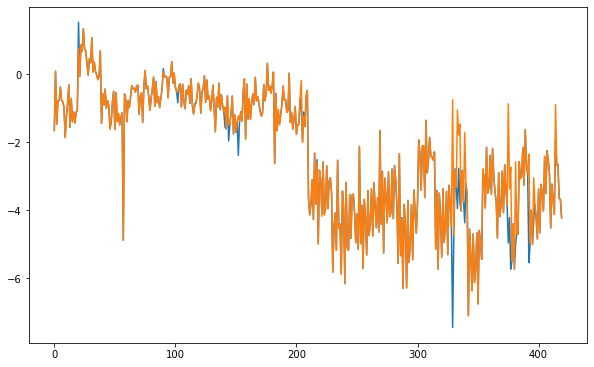

In [41]:

plt.plot(gamma_cutoff_dic[420])
plt.plot(gamma_cutoff_dic[400])
# plt.plot(gamma_cutoff_dic[350], c="red")



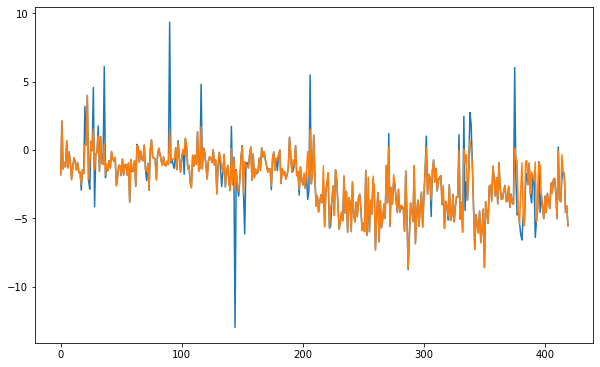

In [455]:

plt.plot(gamma_cutoff_dic[420])
# plt.plot(gamma_cutoff_dic[400])
plt.plot(gamma_cutoff_dic[350])


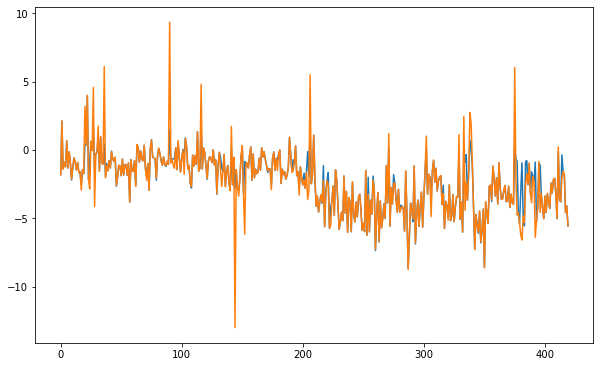

In [454]:
plt.plot(gamma_cutoff_dic[350])
plt.plot(gamma_cutoff_dic[420])
# plt.plot(gamma_cutoff_dic[400])


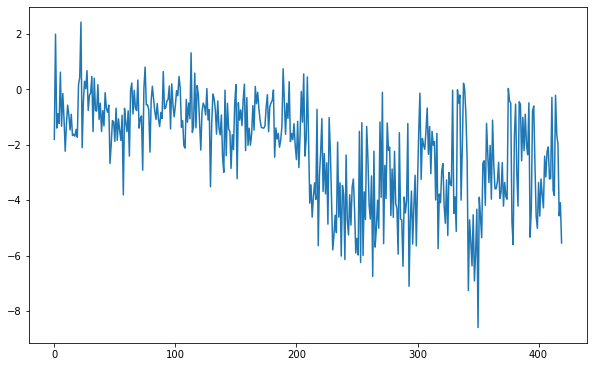

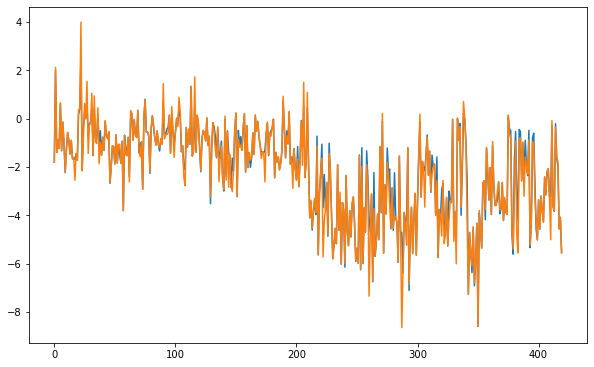

In [457]:
plt.plot(gamma_cutoff_dic[300])
plt.plot(gamma_cutoff_dic[350])


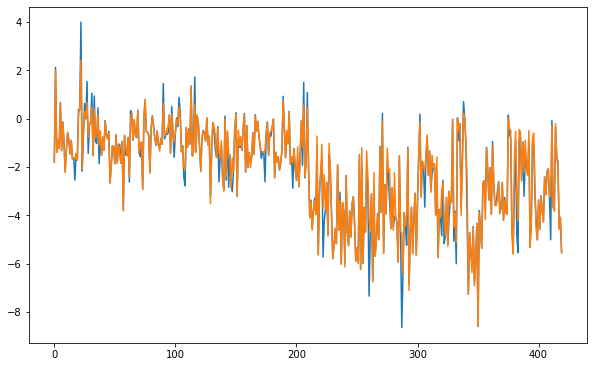

In [456]:
plt.plot(gamma_cutoff_dic[350])
plt.plot(gamma_cutoff_dic[300])

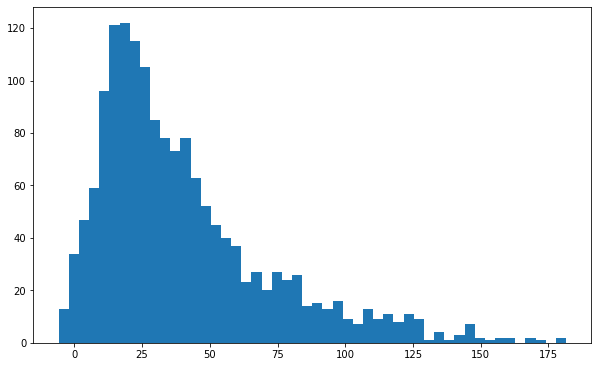

In [450]:
_ = plt.hist(a.dot(gamma_cutoff_dic[350]),bins=50)

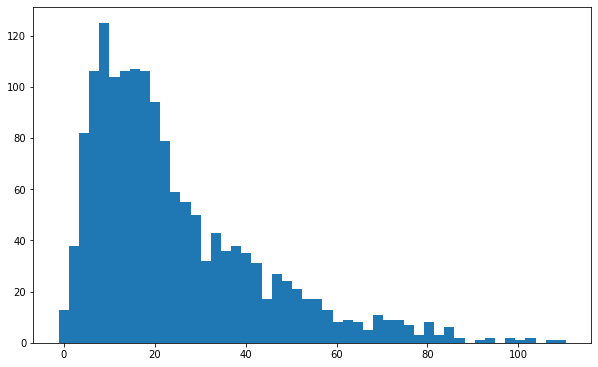

In [416]:
_ = plt.hist(a.dot(sc_v1),bins=50)

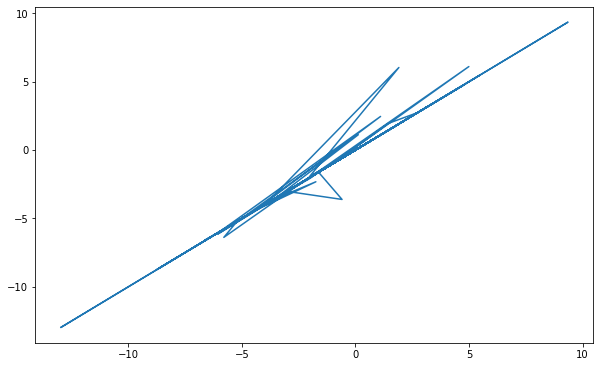

In [409]:
plt.plot(gamma_cutoff_dic[410], gamma_cutoff_dic[420])

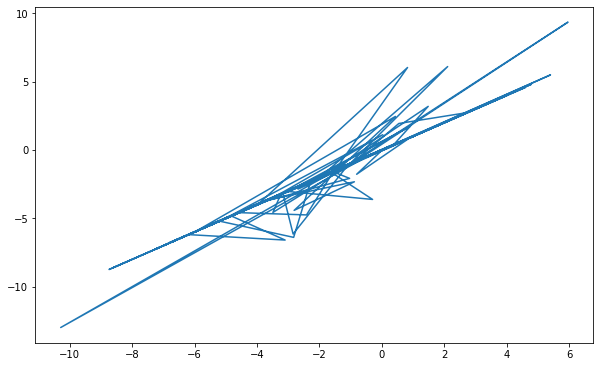

In [414]:
plt.plot(gamma_cutoff_dic[400], gamma_cutoff_dic[420])
# plt.plot()
# plt.plot(gamma_cutoff_dic[420])

In [47]:
sc_v1 = -np.loadtxt("/Users/weilu/Research/server/aug_2020/membrane_protein_structure_prediction/curated_sc_v1.dat")

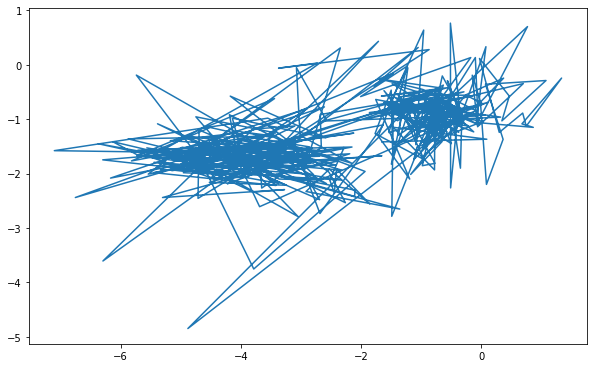

In [49]:
plt.plot(gamma_cutoff_dic[400], sc_v1)

In [51]:
from scipy import stats

stats.pearsonr(gamma_cutoff_dic[400], sc_v1)

(0.566861284168499, 4.486285789312908e-37)

In [52]:
np.savetxt("/Users/weilu/Research/server/aug_2020/membrane_protein_structure_prediction/curated_sc_v2.dat", -gamma_cutoff_dic[400])

In [ ]:
#

In [337]:
a["B"].shape

(420, 420)

In [ ]:
def get_filtered_gamma(pre, cutoff, pp):
    # pp = "cath-dataset-nonredundant-S20Clean_phi_pairwise_contact_well4.5_6.5_5.0_10phi_density_mediated_contact_well6.5_9.5_5.0_10_2.6_7.0"
    # pp = "proteins_name_list_phi_pairwise_contact_well4.5_6.5_5.0_10phi_density_mediated_contact_well6.5_9.5_5.0_10_2.6_7.0phi_burial_well4.0"

    A_name = pp + "_A"
    B_name = pp + "_B"

    A = np.loadtxt(pre+A_name)
    B = np.loadtxt(pre+B_name)


    half_B_name = pp + "_half_B"
    half_B = np.loadtxt(pre+half_B_name)
    other_half_B_name = pp + "_other_half_B"
    other_half_B = np.loadtxt(pre+other_half_B_name)
    std_half_B_name = pp + "_std_half_B"
    std_half_B = np.loadtxt(pre+std_half_B_name)


    # pre = "/Users/weilu/Research/server/april_2019/"
    # location = pre + f"../../phis/{pp}_phi_decoy_summary.txt"
    location = pre + pp + "_A_prime"
    A_prime = np.loadtxt(location)

    lamb, P = np.linalg.eig(B)
    lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
    filtered_lamb = np.copy(lamb)
    cutoff_mode = cutoff
    filtered_B_inv, filtered_lamb, P = get_filtered_B_inv_lambda_and_P(filtered_lamb,
                                                                       cutoff_mode, P)
    filtered_gamma = np.dot(filtered_B_inv, A)
    filtered_B = np.linalg.inv(filtered_B_inv)

    return A, A_prime, filtered_gamma, filtered_B_inv

In [ ]:
pre = "/Users/weilu/Research/server/aug_2020/curated_single_chain_optimization/optimization_decoyN2000/gammas/"
# pp = "quick_126"
pp = "complete_protein_list_phi_gxxxg_v5_well420"
cutoff_i = 300
A, A_prime, filtered_gamma, filtered_B_inv = get_filtered_gamma(pre, cutoff_i, pp)
# c = np.dot(A_prime, original_gamma_deybe)
c = -100 
# if args.constant == 0.0:
#     c = np.dot(A_prime, original_gamma)
# else:
#     c = args.constant
# print("A' gamma = constant:", c)
# do(f"echo 'c {c}\n' >> constant_log")
B_inv = filtered_B_inv
lambda_2 = (A_prime.dot(B_inv).dot(A) - c) / (A_prime.dot(B_inv).dot(A_prime))
gamma_new = B_inv.dot(A-A_prime*lambda_2)

In [ ]:


def calculate_A_B_and_gamma_wl45(training_set_file, phi_list_file_name, decoy_method, num_decoys,
                                    noise_filtering=True, jackhmmer=False, read=True, withBiased=False, oneMinus=True, decoyBiasName='decoysQ', **kwargs):
    phi_list = read_phi_list(phi_list_file_name)
    training_set = read_column_from_file(training_set_file, 1)
    print("Size of training set", len(training_set))
    os.system(f"echo 'Size {len(training_set)}' >> log")
    # Find out how many total phi_i there are and get full parameter string
    total_phis, full_parameters_string, num_phis = get_total_phis_and_parameter_string(
        phi_list, training_set, **kwargs)
    print("Size of phis", total_phis)
    if not read and withBiased:
        phi_i_protein_i_decoyQ = np.zeros(
            (len(training_set), num_decoys, 1))
        for i_protein, protein in enumerate(training_set):
            phi_i_protein_i_decoyQ[i_protein] = read_decoyQ_phis(
                protein, phi_list, total_phis, num_phis, num_decoys, decoy_method, decoyBiasName=decoyBiasName, jackhmmer=jackhmmer, **kwargs)
    if read:
        print("reading native")
        os.system("echo 'Reading native' >> log")
        file_prefix = "%s%s_%s" % (phis_directory, training_set_file.split(
            '/')[-1].split('.')[0], full_parameters_string)
        phi_summary_file_name = file_prefix + '_phi_native_summary.txt'
        phi_native = np.loadtxt(phi_summary_file_name)
    else:
        phi_native_i_protein = np.zeros((len(training_set), total_phis))
        for i_protein, protein in enumerate(training_set):
            phi_native_i_protein[i_protein] = read_native_phi(
                protein, phi_list, total_phis, jackhmmer=jackhmmer, **kwargs)
        if withBiased:
            if oneMinus:
                phi_native_i_protein *= 1 - np.average(phi_i_protein_i_decoyQ, axis=1)
                normalization = np.sum(1 - np.average(phi_i_protein_i_decoyQ, axis=1))
            else:
                phi_native_i_protein *= np.average(phi_i_protein_i_decoyQ, axis=1)
                normalization = np.sum(np.average(phi_i_protein_i_decoyQ, axis=1))
        else:
            normalization = len(training_set)

        phi_native_i_protein *= (len(training_set) / normalization)
        phi_native = np.average(phi_native_i_protein, axis=0)

        # Output to a file;
        file_prefix = "%s%s_%s" % (phis_directory, training_set_file.split(
            '/')[-1].split('.')[0], full_parameters_string)
        phi_summary_file_name = file_prefix + '_phi_native_summary.txt'
        np.savetxt(phi_summary_file_name, phi_native, fmt='%1.5f')

    if read:
        print("Reading phi decoy")
        os.system("echo 'Reading phi decoy' >> log")
        # Output to a file;
        file_prefix = "%s%s_%s" % (phis_directory, training_set_file.split(
            '/')[-1].split('.')[0], full_parameters_string)
        phi_summary_file_name = file_prefix + '_phi_decoy_summary.txt'
        average_phi_decoy = np.loadtxt(phi_summary_file_name)
        phi_all_summary_file_name = file_prefix + '_phi_decoy_all_summary.txt'
        phi_i_protein_i_decoy = np.zeros(
            (len(training_set), num_decoys, total_phis))
        # phi_i_protein_i_decoy = np.loadtxt(phi_all_summary_file_name)
        phi_i_protein_i_decoy = np.reshape(phi_i_protein_i_decoy, (len(training_set), num_decoys, total_phis))
    else:
        phi_i_protein_i_decoy = np.zeros(
            (len(training_set), num_decoys, total_phis))

        for i_protein, protein in enumerate(training_set):
            print(i_protein, protein)
            phi_i_protein_i_decoy[i_protein] = read_decoy_phis(
                protein, phi_list, total_phis, num_phis, num_decoys, decoy_method, jackhmmer=jackhmmer, **kwargs)
        if withBiased:
            if oneMinus:
                phi_i_protein_i_decoy *= 1 - phi_i_protein_i_decoyQ
                normalization = np.sum(1 - phi_i_protein_i_decoyQ)
            else:
                phi_i_protein_i_decoy *= phi_i_protein_i_decoyQ
                normalization = np.sum(phi_i_protein_i_decoyQ)
        else:
            normalization = len(training_set) * num_decoys
        # The phi_i decoy is constructed as the union of all decoys of all proteins in the training set;
        phi_i_protein_i_decoy *= (len(training_set) * num_decoys / normalization)
        phi_i_decoy_reshaped = np.reshape(phi_i_protein_i_decoy,
                                    (len(training_set) * num_decoys, total_phis))
        # average_phi_decoy = np.average(phi_i_decoy_reshaped, axis=0)
        # print("normalization", normalization)
        # print("phi_i_decoy_reshaped", phi_i_decoy_reshaped)
        # # old
        # average_phi_decoy = np.sum(phi_i_decoy_reshaped, axis=0) / normalization
        # # old


        average_phi_decoy = np.average(phi_i_decoy_reshaped, axis=0)
        # print("average_phi_decoy", average_phi_decoy)
        # Output to a file;
        file_prefix = "%s%s_%s" % (phis_directory, training_set_file.split(
            '/')[-1].split('.')[0], full_parameters_string)
        phi_summary_file_name = file_prefix + '_phi_decoy_summary.txt'
        np.savetxt(phi_summary_file_name, average_phi_decoy, fmt='%1.5f')

        phi_all_summary_file_name = file_prefix + '_phi_decoy_all_summary.txt'
        np.savetxt(phi_all_summary_file_name, phi_i_decoy_reshaped, fmt='%1.5f')
        phi_i_decoy_reshaped = None
    # A, B, half_B, other_half_B, std_half_B = calculate_A_and_B(
    #     average_phi_decoy, phi_native, total_phis, num_decoys, phi_i_decoy_reshaped)
    print("done reading")
    os.system("echo 'Done reading' >> log")
    A, B, half_B, other_half_B, std_half_B = calculate_A_and_B_wei(
        average_phi_decoy, phi_native, phi_i_protein_i_decoy)
    phi_i_protein_i_decoy = None  # free its memory
    gamma = np.dot(np.linalg.pinv(B), A)

    # write gamma file
    file_prefix = "%s%s_%s" % (gammas_directory, training_set_file.split(
        '/')[-1].split('.')[0], full_parameters_string)

    gamma_file_name = file_prefix + '_gamma'
#    gamma_file = open(gamma_file_name, 'w')
    np.savetxt(gamma_file_name, gamma, '%1.5f')

    A_file_name = file_prefix + '_A'
#    A_file = open(A_file_name, 'w')
    np.savetxt(A_file_name, A, fmt='%1.5f')

    A_prime_file_name = file_prefix + '_A_prime'
#    A_file = open(A_file_name, 'w')
    np.savetxt(A_prime_file_name, average_phi_decoy, fmt='%1.5f')

    B_file_name = file_prefix + '_B'
#    B_file = open(B_file_name, 'w')
    np.savetxt(B_file_name, B, fmt='%1.5f')

    half_B_file_name = file_prefix + '_half_B'
#    gamma_file = open(gamma_file_name, 'w')
    np.savetxt(half_B_file_name, half_B, '%1.5f')

    other_half_B_file_name = file_prefix + '_other_half_B'
#    gamma_file = open(gamma_file_name, 'w')
    np.savetxt(other_half_B_file_name, other_half_B, '%1.5f')

    std_half_B_file_name = file_prefix + '_std_half_B'
#    gamma_file = open(gamma_file_name, 'w')
    np.savetxt(std_half_B_file_name, std_half_B, '%1.5f')

    # open("%s%s_%s_gamma.dat" % (gammas_directory, training_set_file.split('/')[-1].split('.')[0], full_parameters_string), 'w').write(str(gamma).strip('[]').replace('\n', ' '))

    if noise_filtering:
        filtered_gamma, filtered_B, filtered_lamb, P, lamb = get_filtered_gamma_B_lamb_P_and_lamb(
            A, B, half_B, other_half_B, std_half_B, total_phis, num_decoys)
        # gamma_file_name = "%sfiltered_%s_%s_gamma.dat" % (gammas_directory, training_set_file.split('/')[-1].split('.')[0], full_parameters_string)
        # gamma_file = open(gamma_file_name, 'w')

        filtered_gamma_file_name = file_prefix + '_gamma_filtered'
#        filtered_gamma_file = open(filtered_gamma_file_name, 'w')
        np.savetxt(filtered_gamma_file_name, filtered_gamma, fmt='%1.5f')

        filtered_B_file_name = file_prefix + '_B_filtered'
#        filtered_B_file = open(filtered_B_file_name, 'w')
        np.savetxt(filtered_B_file_name, filtered_B, fmt='%1.5f')

        filtered_lamb_file_name = file_prefix + '_lamb_filtered'
#        filtered_lamb_file = open(filtered_lamb_file_name, 'w')
        np.savetxt(filtered_lamb_file_name, filtered_lamb, fmt='%1.5f')

        P_file_name = file_prefix + '_P'
        # print(P)
        # P_file = open(P_file_name, 'wb')
        # np.savetxt(P_file, P, fmt='%1.5f')
        np.savetxt(P_file_name, P, fmt='%1.5f')

        lamb_file_name = file_prefix + '_lamb'
#        lamb_file = open(lamb_file_name, 'w')
        np.savetxt(lamb_file_name, lamb, fmt='%1.5f')

        # open("%sfiltered_%s_%s_gamma.dat" % (gammas_directory, training_set_file.split('/')[-1].split('.')[0], full_parameters_string), 'w').write(str(filtered_gamma).strip('[]').replace('\n', ' '))

    if noise_filtering:
        # return
        return A, B, gamma, filtered_B, filtered_gamma, filtered_lamb, P, lamb
    else:
        return A, B, gamma



In [ ]:

def phi_gxxxg_v5_well(res_list, neighbor_list, parameter_list):
    info = []
    min_seq_sep = 10
    r_min = 2.0
    r_max = 6.5
    r_cutoff = 8.5
    kappa = 5
    n_parameters = 420
    info_list = []
    get_distance_between_two_residues = get_interaction_distance_com
    phi_gxxxg_well = np.zeros(n_parameters)
    for res1globalindex, res1 in enumerate(res_list):
        res1index = get_local_index(res1)
        res1chain = get_chain(res1)
        for res2 in get_neighbors_within_radius(neighbor_list, res1, r_cutoff):
            res2index = get_local_index(res2)
            res2chain = get_chain(res2)
            res2globalindex = get_global_index(res_list, res2)

            for shift_to_res2_2, direction in zip([-4, 4], ["anti", "parallel"]):
                res1_2_globalindex = res1globalindex + 4
                res1_2 = get_res_by_globalindex(res_list, res1_2_globalindex, res1chain)
                # for shift_to_res2_2 in [-4, 4]:

                # consider parallel, and anti-parallel.
                res2_2_globalindex = res2globalindex + shift_to_res2_2
                res2_2 = get_res_by_globalindex(res_list, res2_2_globalindex, res2chain)
                if res1_2 == -1 or res2_2 == -1:
                    continue
                if direction == "parallel":
                    group2index = res2globalindex
                elif direction == "anti":
                    group2index = res2_2_globalindex
                sep = group2index - res1globalindex
                if (res1chain == res2chain and sep >= min_seq_sep) or (res1chain != res2chain and group2index > res1globalindex):
                    rij = get_distance_between_two_residues(res1, res2)

                    rij_2 = get_distance_between_two_residues(res1_2, res2_2)
                    if rij_2 > r_cutoff or rij > r_cutoff:
                        continue

                    res1_name = res1.resname
                    res1_2_name = res1_2.resname
                    res2_name = res2.resname
                    res2_2_name = res2_2.resname
                    # interaction_index = get_interaction_index_from_four_residues_v5(res1.resname, res1_2.resname, res2.resname, res2_2.resname, direction)
                    interaction_index = get_interaction_index_from_four_residues_v5(res1_name, res1_2_name, res2_name, res2_2_name, direction)
                    phi_ = interaction_well(rij, r_min, r_max, kappa) * interaction_well(rij_2, r_min, r_max, kappa)
                    # phi_gxxxg_well[interaction_index] += phi_
                    phi_gxxxg_well[interaction_index] += phi_
                    info.append([phi_, res1globalindex, res1_2_globalindex, res2globalindex, res2_2_globalindex, direction, res1_name, res1_2_name, res2_name, res2_2_name, interaction_index])

    phis_to_return = []
    for i in range(n_parameters):
        phis_to_return.append(round(phi_gxxxg_well[i],4))
    return phis_to_return

In [ ]:
n_parameters = 420
phi_gxxxg_well = np.zeros(n_parameters)
for i, line in info.iterrows():
    interaction_index = line["interaction_index"]
    phi = line["phi"]
    phi_gxxxg_well[interaction_index] += phi
phis_to_return = []
for i in range(n_parameters):
    phis_to_return.append(phi_gxxxg_well[i])

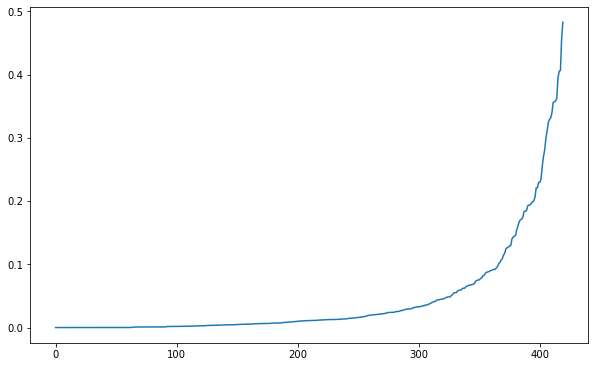

In [120]:
plt.plot(range(len(b_mean)), b_mean)

In [133]:
msa_info = pd.read_csv("/Users/weilu/Research/server/aug_2020/curated_single_chain_optimization/alignments/msa_info.csv", index_col=0)

In [135]:
msa_info.sort_values("count")

,count,name
973,2,6bhp_A_filtered_0.05.seqs
375,4,5v8k_A_filtered_0.05.seqs
431,29,5ofp_A_filtered_0.05.seqs
139,30,4pl0_B_filtered_0.05.seqs
552,48,6grj_B_filtered_0.05.seqs
...,...,...
1364,3691,6a95_A_filtered_0.05.seqs
169,3788,6hum_F_filtered_0.05.seqs
899,3795,5xsy_A_filtered_0.05.seqs
386,3810,5xtc_l_filtered_0.05.seqs


In [139]:
# exclude MSA count less than 1000
selected = msa_info.query("count > 1000")
selected_pdb = selected["name"].to_list()
selected_pdbs = [pdb[:6] for pdb in selected_pdb]

In [157]:
with open("/Users/weilu/Research/server/aug_2020/curated_single_chain_optimization/pdbs_list_msa_count_above_1000", "w") as out:
    for pdb in selected_pdbs:
        out.write(f"{pdb}\n")

In [155]:
len(selected_pdbs)

1573

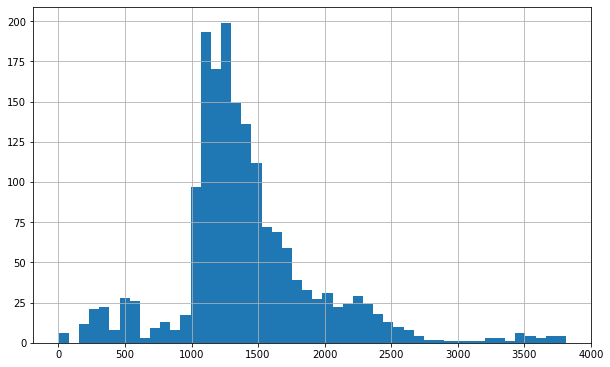

In [138]:
msa_info["count"].hist(bins=50)

In [ ]:

def calculate_A_and_B_wei(average_phi_decoy, phi_native, all_phis, reduceMemory=True):
    A = average_phi_decoy - phi_native
    size_of_training_set, num_decoys, total_phis = all_phis.shape
    half_B = np.zeros((total_phis, total_phis))
    std_half_B = np.zeros((total_phis, total_phis))
    other_half_B = np.zeros((total_phis, total_phis))
    if reduceMemory:
        for p in range(size_of_training_set):
            phis_i = all_phis[p].reshape(num_decoys, total_phis, 1)
            for j in range(total_phis):
                phis_j = phis_i[:, j].reshape(num_decoys, 1, 1)
                half_B[j] += np.average(phis_i * phis_j, axis=0).reshape(total_phis)
                std_half_B[j] += np.std(phis_i * phis_j, axis=0).reshape(total_phis)
    else:
        for p in range(size_of_training_set):
            phis_i = all_phis[p].reshape(num_decoys, total_phis, 1)
            phis_j = all_phis[p].reshape(num_decoys, 1, total_phis)
            half_B += np.average(phis_i * phis_j, axis=0)
            std_half_B += np.std(phis_i * phis_j, axis=0)
    half_B /= size_of_training_set
    std_half_B /= size_of_training_set

    for p in range(size_of_training_set):
        average_phi = np.average(all_phis[p], axis=0)
        other_half_B += average_phi.reshape(total_phis, 1) * average_phi.reshape(1, total_phis)
    other_half_B /= size_of_training_set

    B = half_B - other_half_B

    return A, B, half_B, other_half_B, std_half_B



In [208]:
average_phi_decoy = np.loadtxt("/Users/weilu/Research/server/aug_2020/experimenting_optimization/phis/protein_list_phi_gxxxg_v5_well420_phi_decoy_summary.txt")

In [209]:
phi_native = np.loadtxt("/Users/weilu/Research/server/aug_2020/experimenting_optimization/phis/protein_list_phi_gxxxg_v5_well420_phi_native_summary.txt")

In [264]:
all_phis = np.loadtxt("/Users/weilu/Research/server/aug_2020/experimenting_optimization/phis/protein_list_phi_gxxxg_v5_well420_phi_decoy_all_summary.txt")

In [265]:
all_phis.shape

(300, 420)

In [266]:
training_set_length = 3
num_decoys = 100
total_phis = 420
all_phis = np.reshape(all_phis, (training_set_length, num_decoys, total_phis))

In [213]:
all_phis.shape

(3, 100, 420)

In [229]:
A, B, half_B, other_half_B, std_half_B = calculate_A_and_B_wei(average_phi_decoy, phi_native, all_phis[0:1,:,:], reduceMemory=True)

calculate_A_and_B
End


In [267]:
total_phis = 420
num_decoys = 100
phi_i_decoy = all_phis[0,:,:]
a, b, half_b, other_half_b, std_half_b = calculate_A_and_B_wei(average_phi_decoy, phi_native, all_phis[0])

In [268]:
abs(other_half_B-other_half_b).sum()

0.0

In [269]:
abs(half_B-half_b).sum()

0.0

In [270]:
abs(half_B-half_b).max()

0.0

In [271]:
abs(a-A).sum()

0.0

In [276]:
a = np.loadtxt("/Users/weilu/Research/server/aug_2020/experimenting_optimization/optimization_quick/gammas/protein_list_phi_gxxxg_v5_well420_A")
b = np.loadtxt("/Users/weilu/Research/server/aug_2020/experimenting_optimization/optimization_quick/gammas/protein_list_phi_gxxxg_v5_well420_B")

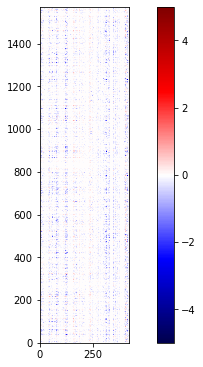

In [354]:
plt.imshow(a, origin=0, vmin=-5, vmax=5, cmap='seismic')
plt.colorbar()

In [203]:
np.save(f"/Users/weilu/Research/server/aug_2020/curated_single_chain_optimization/optimization_msa/decoys/{pdb}.npy", chosen_decoys)
np.save(f"/Users/weilu/Research/server/aug_2020/curated_single_chain_optimization/optimization_msa/phis/{pdb}.npy", decoy_phis)
np.save(f"/Users/weilu/Research/server/aug_2020/curated_single_chain_optimization/optimization_msa/phis/{pdb}_native.npy", chosen_msa)




In [197]:
a = np.load(f"/Users/weilu/Research/server/aug_2020/curated_single_chain_optimization/optimization_msa/phis/{pdb}.npy")

In [200]:
b = np.load(f"/Users/weilu/Research/server/aug_2020/curated_single_chain_optimization/optimization_msa/phis/test.npy")

In [296]:
n_parameters = 420
n_msa = len(msa)
msa_phis = np.zeros((n_msa, n_parameters))
for i in range(n_msa):
    phis = get_phis_from_info_and_sequence(info, msa[i])
    msa_phis[i] = phis

In [300]:
a = msa_phis.mean(axis=0)
b = native_phis.mean(axis=0)
c = native_phis.std(axis=0)

<ErrorbarContainer object of 3 artists>

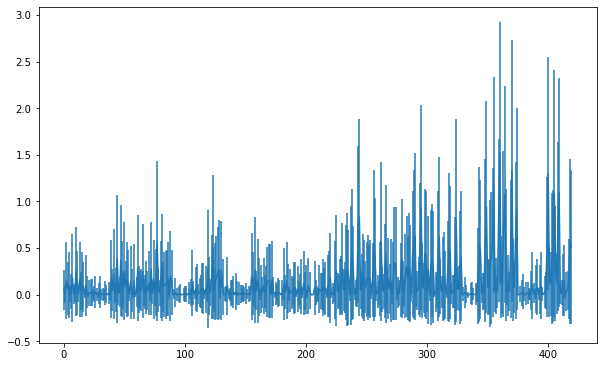

In [304]:
plt.errorbar(range(len(a)), a, yerr=c)

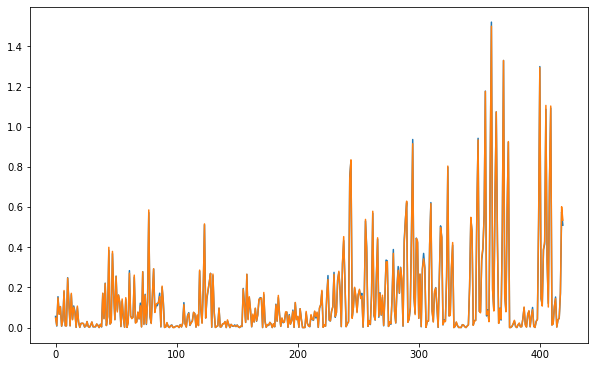

In [299]:
plt.plot(a)
plt.plot(b)